<a href="https://colab.research.google.com/github/DSGP-Group-1-EAPS/SL-Apparel-Dataset/blob/Kavindu-Deshanjana/ARIMA_and_SARIMA_for_Sewing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries

In [42]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

### Mounting the Drive

In [11]:
# Mount Google Drive
drive.mount('/content/drive')

# Load preprocessed data from Excel file
file_path = '/content/drive/MyDrive/DSGP_COURSEWORK/SL Apparel Dataset model/Dataset/preprocessed_data_new.xlsx'
data = pd.read_excel(file_path)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### EDA

In [12]:
# Define a mapping of sub-departments to main departments
sub_dept_to_main_dept = {
    'Sewing Team': [sub_dept for sub_dept in data['Department'] if sub_dept.startswith('Sewing Team')]
}

# Map each sub-department to its main department
main_dept_for_sub_dept = {}
for main_dept, sub_depts in sub_dept_to_main_dept.items():
    for sub_dept in sub_depts:
        main_dept_for_sub_dept[sub_dept] = main_dept

# Add a new column indicating the main department for each row
data['MainDepartment'] = data['Department'].map(main_dept_for_sub_dept)

In [13]:
# Summarize total absence by main department
total_absence_by_main_dept = data.groupby(['LeaveYear','LeaveMonth','MainDepartment']).size().reset_index(name='totalAbsence')
print(total_absence_by_main_dept)

    LeaveYear  LeaveMonth MainDepartment  totalAbsence
0        2021          12    Sewing Team          2870
1        2022           1    Sewing Team          1963
2        2022           2    Sewing Team          2064
3        2022           3    Sewing Team          2048
4        2022           4    Sewing Team          1543
5        2022           5    Sewing Team          2987
6        2022           6    Sewing Team          2544
7        2022           7    Sewing Team          1319
8        2022           8    Sewing Team          1489
9        2022           9    Sewing Team          1365
10       2022          10    Sewing Team          1659
11       2022          11    Sewing Team          1426
12       2022          12    Sewing Team           987
13       2023           1    Sewing Team           919
14       2023           2    Sewing Team           312
15       2023           3    Sewing Team          1032
16       2023           4    Sewing Team           433
17       2

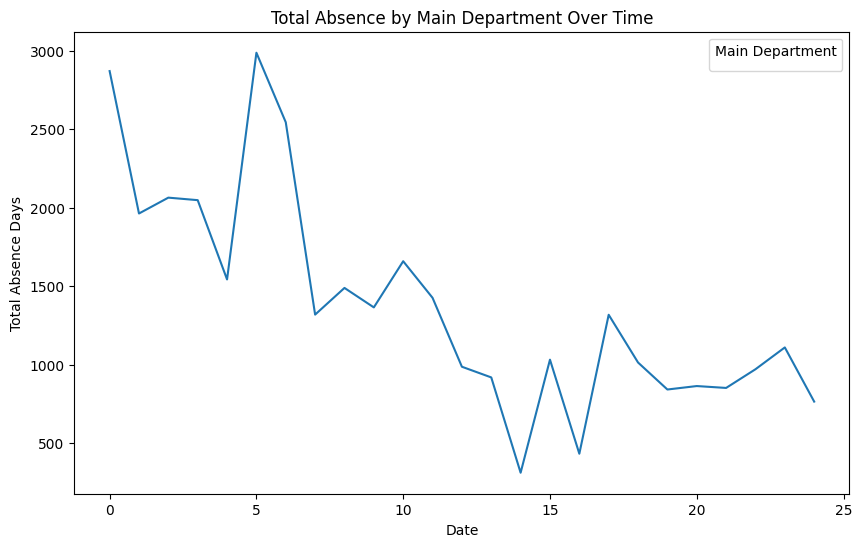

In [14]:
# Visualize the data
plt.figure(figsize=(10, 6))
plt.plot(total_absence_by_main_dept['totalAbsence'])
plt.title('Total Absence by Main Department Over Time')
plt.xlabel('Date')
plt.ylabel('Total Absence Days')
plt.legend(title='Main Department')
plt.show()

### ADF Test

In [15]:
# Check for stationarity
def adf_test(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

### Splitting Data

In [16]:
# Train-test split
train_size = int(len(total_absence_by_main_dept['totalAbsence']) * 0.8)
train, test = total_absence_by_main_dept['totalAbsence'].iloc[:train_size], total_absence_by_main_dept['totalAbsence'].iloc[train_size:]

### ARIMA Model

In [17]:
# Fit ARIMA model for each main department
model = ARIMA(train, order=(4,1,0))
model_fit = model.fit()

### Evaluating Model

                               SARIMAX Results                                
Dep. Variable:           totalAbsence   No. Observations:                   20
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -145.015
Date:                Mon, 26 Feb 2024   AIC                            300.030
Time:                        04:08:11   BIC                            304.752
Sample:                             0   HQIC                           300.829
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5979      0.304     -1.966      0.049      -1.194      -0.002
ar.L2         -0.3951      0.297     -1.331      0.183      -0.977       0.187
ar.L3         -0.2740      0.361     -0.759      0.4

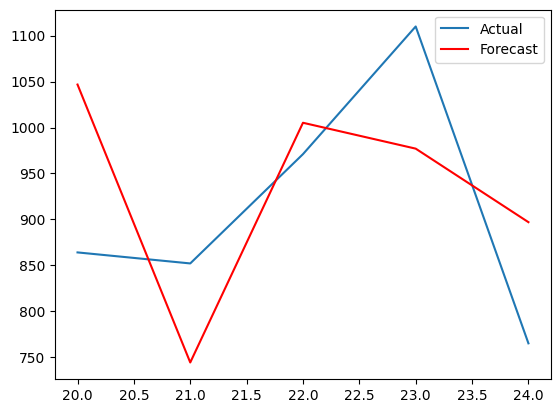

In [18]:
print(model_fit.summary())

forecast = model_fit.forecast(steps=len(test))
print(forecast)

mse = mean_squared_error(test, forecast)
print("MSE : ", mse)

rsme = np.sqrt(mse)
print("RSME : ", rsme)

plt.plot(test, label="Actual")
plt.plot(forecast, label="Forecast", color="red")
plt.legend()
plt.show()


### SARIMA Model
## ADF Test

In [46]:
# Check for stationarity
def adf_test(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))


## Splitting Data

In [47]:
# Train-test split
train_size = int(len(total_absence_by_main_dept['totalAbsence']) * 0.8)
train, test = total_absence_by_main_dept['totalAbsence'].iloc[:train_size], total_absence_by_main_dept['totalAbsence'].iloc[train_size:]


## EDA

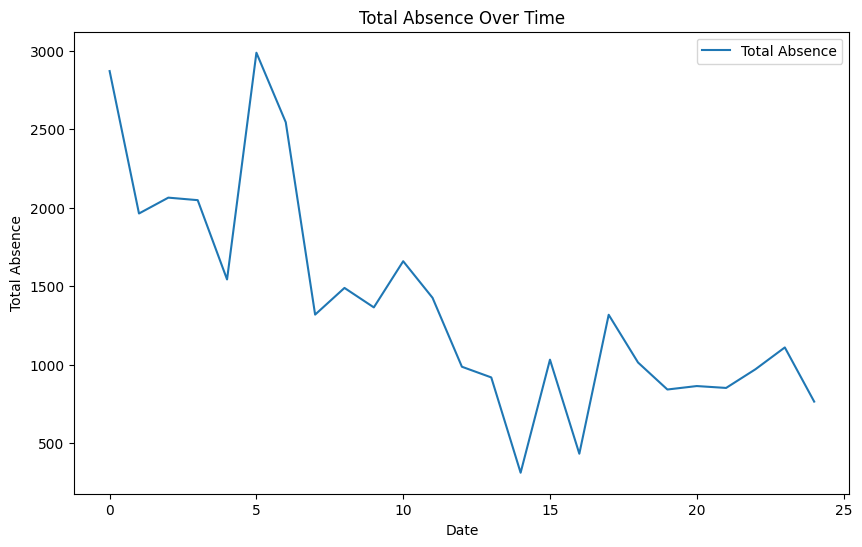

Descriptive Statistics:
count      25.000000
mean     1387.840000
std       696.671472
min       312.000000
25%       919.000000
50%      1318.000000
75%      1659.000000
max      2987.000000
Name: totalAbsence, dtype: float64


In [22]:
# EDA
# Data Visualization
plt.figure(figsize=(10, 6))
plt.plot(total_absence_by_main_dept['totalAbsence'], label='Total Absence')
plt.title('Total Absence Over Time')
plt.xlabel('Date')
plt.ylabel('Total Absence')
plt.legend()
plt.show()

# Descriptive Statistics
print("Descriptive Statistics:")
print(total_absence_by_main_dept['totalAbsence'].describe())

## SARIMA Model


In [23]:
# SARIMA modeling (continued from original code)
order = (4, 1, 0)  # Non-seasonal parameters
seasonal_order = (1, 1, 1, 12)  # Seasonal parameters, here assuming a yearly seasonal pattern

# Fit SARIMA model
model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
model_fit = model.fit(disp=False)

# Forecast
forecast = model_fit.forecast(steps=len(test))
print(forecast)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


20    1011.999340
21     887.999372
22    1181.999154
23     948.998980
24     509.998534
Name: predicted_mean, dtype: float64


### Evaluating the *Model*

MSE: 31733.495654667953
RMSE: 178.13897848216138


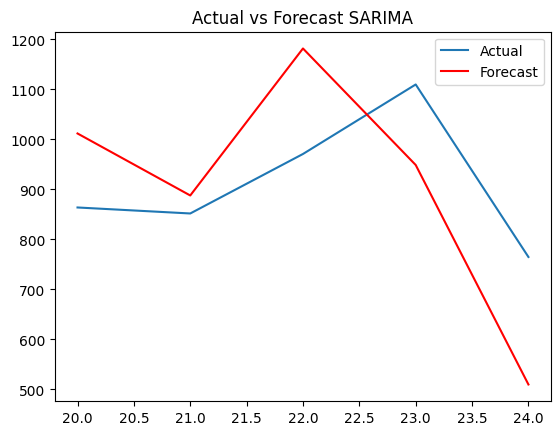

                                      SARIMAX Results                                       
Dep. Variable:                         totalAbsence   No. Observations:                   20
Model:             SARIMAX(4, 1, 0)x(1, 1, [1], 12)   Log Likelihood        -10558911976.507
Date:                              Mon, 26 Feb 2024   AIC                    21117823967.015
Time:                                      04:13:33   BIC                    21117823966.636
Sample:                                           0   HQIC                   21117823962.335
                                               - 20                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1       3.344e-08   3.09e-10    108.154      0.000    3.28e-08     3.4e-08
ar.L2      -3.264e-

In [24]:
# Calculate MSE and RMSE
mse = mean_squared_error(test, forecast)
print("MSE:", mse)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

# Visualize actual vs forecast
plt.plot(test, label="Actual")
plt.plot(forecast, label="Forecast", color="red")
plt.legend()
plt.title('Actual vs Forecast SARIMA')
plt.show()

print(model_fit.summary())